# Multilinear Regression and Supervised Learning

In this assignment, you will explore the regression and classification models that we discussed in class. While the class discussion was focused on theory, the focus here is on applying the methods to data.

We'll use a couple of new packages for loading and manipulating data:
 - `seaborn` is mostly for visualization of statistical analyses of data, but has some useful datasets that can be loaded from the package
 - `pandas` is a useful tool for working with spreadsheet-style data (technically, the data type used here is called a "dataframe")

In [33]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Multilinear Regression

### Loading Data

We'll load a dataset containing various statistics about car models, including their typical miles-per-gallon (mpg).

In [62]:
mpg_data = sns.load_dataset("mpg")

To get an idea for what the data looks like, we can look at the first few lines using the following command.

In [63]:
mpg_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


We can see that there are 398 data samples with 9 pieces of information per sample.

In [64]:
mpg_data.shape

(398, 9)

However, if we look through the data, we see that some entries in the 'horsepower' column are not numbers.

In [65]:
np.array(mpg_data['horsepower'])

array([130., 165., 150., 150., 140., 198., 220., 215., 225., 190., 170.,
       160., 150., 225.,  95.,  95.,  97.,  85.,  88.,  46.,  87.,  90.,
        95., 113.,  90., 215., 200., 210., 193.,  88.,  90.,  95.,  nan,
       100., 105., 100.,  88., 100., 165., 175., 153., 150., 180., 170.,
       175., 110.,  72., 100.,  88.,  86.,  90.,  70.,  76.,  65.,  69.,
        60.,  70.,  95.,  80.,  54.,  90.,  86., 165., 175., 150., 153.,
       150., 208., 155., 160., 190.,  97., 150., 130., 140., 150., 112.,
        76.,  87.,  69.,  86.,  92.,  97.,  80.,  88., 175., 150., 145.,
       137., 150., 198., 150., 158., 150., 215., 225., 175., 105., 100.,
       100.,  88.,  95.,  46., 150., 167., 170., 180., 100.,  88.,  72.,
        94.,  90.,  85., 107.,  90., 145., 230.,  49.,  75.,  91., 112.,
       150., 110., 122., 180.,  95.,  nan, 100., 100.,  67.,  80.,  65.,
        75., 100., 110., 105., 140., 150., 150., 140., 150.,  83.,  67.,
        78.,  52.,  61.,  75.,  75.,  75.,  97.,  9

We'll remove any rows from our data where `nan` appears.

In [66]:
mpg_data = mpg_data.dropna()

In [67]:
mpg_data.shape

(392, 9)

Now let's fit this into the regression framework that we described in class. 

We will train our model to predict mpg from the remaining numerical variables (cylinders, displacement, horsepower, weight, acceleration, model_year). This means that our data matrix should be of the form
$$
X = \left[\begin{array}{c}
\vec{x}_1^T \\
\vdots \\
\vec{x}_{398}^T \end{array}\right] \in \mathbb{R}^{398 \times 6},
$$
where each $\vec{x}_i$ is a vector of 6 numerical measurements for car model $i$. The vector we are trying to predict is of the form
$$
\vec{y} = \left[\begin{array}{c}
y_1 \\
\vdots \\
y_{398}\end{array}\right] \in \mathbb{R}^{398},
$$
where each $y_i$ is the mpg for care model $i$. 

Let's set these up as `numpy` arrays:

In [68]:
X = np.array(mpg_data[['cylinders','displacement','horsepower','weight','acceleration','model_year']])
y = np.array(mpg_data['mpg'])

In [69]:
col1 = [1 for i in range(X.shape[0])]

In [70]:
X2 = pd.DataFrame(X)

In [71]:
X = pd.DataFrame()

In [72]:
X[0] = col1

In [73]:
X = pd.concat((X,X2),axis = 1)

In [74]:
X = np.array(X)

In [75]:
X

array([[1.000e+00, 8.000e+00, 3.070e+02, ..., 3.504e+03, 1.200e+01,
        7.000e+01],
       [1.000e+00, 8.000e+00, 3.500e+02, ..., 3.693e+03, 1.150e+01,
        7.000e+01],
       [1.000e+00, 8.000e+00, 3.180e+02, ..., 3.436e+03, 1.100e+01,
        7.000e+01],
       ...,
       [1.000e+00, 4.000e+00, 1.350e+02, ..., 2.295e+03, 1.160e+01,
        8.200e+01],
       [1.000e+00, 4.000e+00, 1.200e+02, ..., 2.625e+03, 1.860e+01,
        8.200e+01],
       [1.000e+00, 4.000e+00, 1.190e+02, ..., 2.720e+03, 1.940e+01,
        8.200e+01]])

### Building a Multilinear Regression Model

Recall the general setup for multilinear regression: give a data matrix $X \in \mathbb{R}^{N \times d}$ with $N$ samples and $d$ features and a vector of observations $\vec{y} \in \mathbb{R}^N$, our goal is to find parameters $\beta_0,\beta_1,\ldots,\beta_d$ such that the loss function
$$
L(\beta_0,\ldots,\beta_d) = \sum_{i=1}^N \left( y_i - (\beta_0 + \beta_1 (\vec{x}_i)_1 + \cdots + \beta_d (\vec{x}_i)_d) \right)^2.
$$
In this formula, $y_i$ is the $i$th entry of $\vec{y}$, $\vec{x}_i$ is the $i$th data sample (so $\vec{x}_i^T$ is the $i$th row of $X$), and $(\vec{x}_i)_j$ is the $j$th entry of the data vector $\vec{x}_i$.

We will now build our model, which means finding the best parameters. There are a couple of sublties that we didn't address in class, which we will handle now.

### Adding Bias

To incorporate the $\beta_0$ term (this is sometimes referred to in machine learning as the *bias*) in the model, we need to do is add a column of all ones to our data matrix $X$. After we do this, all of the other analysis that we did in class will still go through.

**Problem 1.** Fix the data matrix `X` defined above by adding a column of ones. Do this so that the *first* column contains ones. That is, the current $X \in \mathbb{R}^{398 \times 6}$ should be replaced by a new $X \in \mathbb{R}^{398 \times 7}$ whose first column contains all ones and whose remaining columns are copied over from the original data matrix.

**Note:** Code below will assume that your new data matrix is still called `X`.

In [41]:
## Your code goes here

X0 = np.zeros([X.shape[0],X.shape[1]+1])

for j in range(X0.shape[0]):
    X0[j,:] = np.concatenate([X[j,:],[1]])

In [42]:
X = X0

### Train-Test Split

Typically when one trains a model, it is trained on a subset of the data. The resulting model can then be tested on the remaining data that it did not see during the training phase. The following code picks out a percentage of rows from $X$ randomly, together with corresponding entries of $\vec{y}$, as the 'training set' and leaves the rest out as a 'testing set'.

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### Training the Model

Now recall that we found an explicit formula for the optimal parameters in the multilinear regression problem. Let $\vec{\beta} = [\beta_0 \beta_1 \cdots \beta_d]^T$ be the optimal parameter vector. It is given by the formula
$$
\vec{\beta} = \left(X^T X\right)^{-1} X^T \vec{y}.
$$

**Problem 2.** Find the optimal parameters for the training set using the formula above. Call your optimal parameter vector `betas`. Print out your answer. 

**Remark:** You need to figure out python code for the various matrix manipulations (transposes, inverting a matrix, etc.). Feel free to search the internet and/or discuss the problem with classmates to figure out how to do this!

In [77]:
## Your code goes here.

betas = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train

In [78]:
betas

array([-1.91150915e+01, -8.40663157e-02,  6.30158266e-03,  1.39380615e-02,
       -7.35909497e-03,  1.03896488e-01,  7.99028186e-01])

We can test the performance of our model by making predictions on the testing data, which was not incorporated into our training step. 

**Problem 3.** Create a vector `y_pred` containing the predicted `mpg` values of the data from your testing set. 

**Hint:** This can be done by multiplying a certain matrix with a certain vector.

In [79]:
## Your code goes here.

y_pred = X_test@betas

The code below plots the predicted `mpg` values on the test set, versus the true values from `y_test`. The results look reasonable, but to get a real feel for the quality of our results, we would want to test against other models.

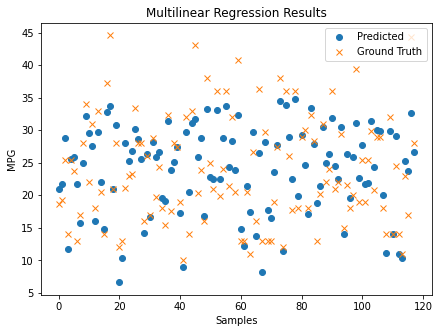

In [80]:
plt.figure(figsize = (7,5))
plt.plot(y_pred,'o', label = 'Predicted')
plt.plot(y_test,'x', label = 'Ground Truth')
plt.title('Multilinear Regression Results')
plt.xlabel("Samples")
plt.ylabel("MPG")
plt.legend()
plt.show()

## Supervised Learning for Classification

The multilinear regression model we created above is designed for predicting a continuous observation. Many machine learning models are designed to predict labels for labeled data (e.g., images). We will now explore some of these methods.

### Loading the Data

For this part of the notebook, we'll use the (small, built-in `sklearn` version of the) MNIST dataset of handwritten digits. 

In [ ]:
from sklearn import datasets
digits = datasets.load_digits()

Recall that the data consists of many handwritten digits and their correct labels.

In [ ]:
fig = plt.figure(figsize=(10,5))

for j in range(10):
    fig.add_subplot(2,5,j+1)
    plt.imshow(digits.images[j], cmap='gray')

We can treat each image as a vector in $\mathbb{R}^{8 \times 8} \approx \mathbb{R}^{64}$. Conveniently, `digits.data` reshapes each image into a 64 dimensional vector. Let's create a train/test split of this vectorized data.

In [ ]:
from sklearn.model_selection import train_test_split

MNIST = digits.data
MNISTlabels = digits.target

MNIST_train, MNIST_test, MNISTlabels_train, MNISTlabels_test = train_test_split(MNIST, MNISTlabels)

As we discussed in class, we can use Logistic Regression for classification. The version that we discussed in class was only for classifying datasets with two labels ('cats' versus 'dogs', say), but this can be generalized to handle datasets with an arbitrary number of labels. In this case, we have 10 labels (one for each digit). 

The code below trains the logistic regression model on the training data (i.e., finds the best parameters for the model). This is standard `sklearn` syntax. Note that this training process uses a version of gradient descent to find optimal values, rather than an explicit formula as in the multilinear regression example.

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', multi_class = 'multinomial', max_iter=10000)
model.fit(MNIST_train, MNISTlabels_train)

Logistic regression with two labels works by finding a good hyperplane to split the two classes of data vectors (for precise definitions, refer back to the lecture notes). For multiclass logistic regression, we get a hyperplane for each class label. This can be seen in the shape of the coefficients for the model:

In [ ]:
model.coef_.shape

Now we can predict a label for each digit in our testing set. This is done using the built-in `predict` function for the model.

In [ ]:
MNIST_predicted = model.predict(MNIST_test)

Let's take a look at some of the samples from our testing set, along with their predicted labels.

In [ ]:
fig = plt.figure(figsize=(10,10))

for j in range(20):
    fig.add_subplot(4,5,j+1)
    plt.imshow(MNIST_test[j].reshape(8,8), cmap='gray')
    plt.axis('off')
    plt.title('Pred. Label='+str(MNIST_predicted[j]))

plt.show()

These results look pretty good. We can compute the overall prediction accuracy using the `score` function.

In [ ]:
print('Prediction Accuracy:',np.round(model.score(MNIST_test,MNISTlabels_test),2))

Logistic regression performs extremely well! It will probably be hard to beat this, but let's practice with some other models:

**Problem 4.** Repeat the above classification process using a different classification model. You can take your pick from [Multilayer Perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron) (a simple neural network), [Decision Tree](https://scikit-learn.org/stable/modules/tree.html#classification), [Support Vector Machine](https://scikit-learn.org/stable/modules/svm.html#classification), or any other model that you like.

**Remark:** If you haven't done this before, you'll need to dig into the documentation a little bit to see how these work. The syntax is mostly similar to the logistic regression model. The mathematical details of several of these models will be described in final project presentations!

In [ ]:
## Your code goes here.

